# Optimum parameters $\gamma_0$

In [1]:
# import API
import pwpp
from pwpp import *
from matplotlib import cm
import matplotlib.ticker as ticker
import pickle
filename='Optimum_g0'
import matplotlib.colors as colors

In [2]:
# load
infile = open(filename,'rb')
Elst, E0lst, W0opt_th, Npopt_th = pickle.load(infile)
infile.close()

In [3]:
# parameters
# laser
lbd = 0.8; #[\mu m]
tau = 35; #[fs]
w0 = 2*pi*c/(lbd*1e-6)*hbar/e*1e-9; #[GeV]
n = tau*c/(lbd*1e-6)*1e-15; #[]
W0lst = np.linspace(2,12,60); #[\mu m] 30
# beam
sigmax = 24.4; #[\mu m]
sigmay = 29.6; #[\mu m]
R = (sigmax+sigmay)/2*sqrt(2); #[\mu m]
L = 200; #[\mu m]
nb = 1e16; #[cm^-3]
nb = nb * 1e-12; #[\mu m^-3]
Nb = nb*(pi*R**2*L); #[]

In [171]:
Elst = np.linspace(100,1000,35) #25
E0lst = np.linspace(1,20,30) #20

In [172]:
W0opt_th = np.zeros((len(Elst),len(E0lst)))
Npopt_th = np.zeros((len(Elst),len(E0lst)))

for i in trange(len(Elst)):
    for j in range(len(E0lst)):
        
        E0 = E0lst[j]; #[GeV]
        g0 = E0/m; #[]
        
        E = Elst[i]; #[J]
        a0max = sqrt(E/tau/(2.149e-5))*(lbd/min(W0lst)); #[]
        
        # Interpolate N+
        amin = 1; #[]
        a0int = np.linspace(amin,a0max,100); #[]
        Npint = np.array([Np(g0, a, w0, n)[0] for a in a0int]); #[]
        Npinterp1d = interpolate.interp1d(a0int, Npint); #[]
        
        NpW0 = np.zeros(len(W0lst)); #[]
        for k in range(len(W0lst)):
            W0 = W0lst[k]; #[\mu m]
            a0 = sqrt(E/tau/(2.149e-5))*(lbd/W0); #[]

            # analytical distribution
            def dNda(a,a0,W0):
                """theory"""
                zR = pi*W0**2/lbd; #[\mu m]
                az = a0/sqrt(1+(L/4/zR)**2)
                return np.piecewise(a, [a > az, a <= az], [lambda a: 4*pi*nb*W0**2*zR/a * 1/3/a * sqrt(a0**2-a**2) * ((a0/a)**2+2),
                                                           lambda a: 4*pi*nb*W0**2*zR/a * L/4/zR * (1+(L/4/zR)**2/3) ])

            alst = np.linspace(amin,a0,200);
            dNp = Npinterp1d(alst);
            ddNda = dNda(alst,a0,W0);

            NpW0[k] = np.trapz(ddNda * dNp, alst)
        W0opt_th[i,j], Npopt_th[i,j] = W0lst[np.argmax(NpW0)], max(NpW0)

In [178]:
# save
outfile = open('Optimum_g0_highres','wb')
pickle.dump([Elst, E0lst, W0opt_th, Npopt_th],outfile)
outfile.close()

In [ ]:
ratioarr = max(E0lst)/max(Elst)
ratioplt = 1/2
ratioadj = 0.635

plt.style.use("style.txt")
fig, axes =  plt.subplots(nrows=1, ncols=2,figsize=(12,3.2))

def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

im0 = axes[0].imshow(W0opt_th.T, interpolation='bilinear', origin='lower', extent=[min(Elst), max(Elst), min(E0lst), max(E0lst)],aspect=ratioplt/ratioarr,
              vmax=np.max(W0opt_th), vmin=np.min(W0opt_th), cmap=cm.Blues_r)
axes[0].images.append(im0)
axes[0].set_xlabel(r'$\varepsilon[\mathrm{J}]$')
axes[0].set_ylabel(r'$E_0[\mathrm{GeV}]$',labelpad=15)
axes[0].set_yticks([5,10,15,20])
axes[0].tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True, color='white')
axes[0].tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True, color='white')
cbar0 = fig.colorbar(im0, ax=axes[0],fraction=ratioadj*ratioarr/ratioplt, pad=0.02)
#cbar0.set_ticks([2,4,6,8,10])
cbar0.set_ticks([3,5,7,9,11])
cbar0.set_label(r'$W_0[\mu\mathrm{m}]$',labelpad=1,y=0.5)
#axes[0].set_aspect(aspect=4/3)

im1 = axes[1].imshow(Npopt_th.T*1e-9, interpolation='bilinear', origin='lower', extent=[min(Elst), max(Elst), min(E0lst), max(E0lst)],aspect=ratioplt/ratioarr,
             vmax=np.max(Npopt_th*1e-9), vmin=np.min(Npopt_th*1e-9) , cmap=cm.Blues_r)
#norm=colors.LogNorm()
axes[1].images.append(im1)
axes[1].set_xlabel(r'$\varepsilon[\mathrm{J}]$')
axes[1].set_ylabel(r'$E_0[\mathrm{GeV}]$',labelpad=15)
axes[1].set_yticks([5,10,15,20])
axes[1].tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True, color='white')
axes[1].tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True, color='white')
cbar1 = fig.colorbar(im1, ax=axes[1],fraction=ratioadj*ratioarr/ratioplt, pad=0.02)
cbar1.set_ticks([0.5,1,1.5,2,2.5])
cbar1.set_label(r'$\times 10^9 ~N_+ \left[ \frac{n_b}{10^{16}~ \mathrm{cm}^{-3}} \right]$',labelpad=5,y=0.5)
#axes[1].set_aspect(aspect=4/3)

plt.tight_layout()
#plt.savefig('epsg0.pdf')
plt.show()

In [177]:
from scipy import interpolate

f = interpolate.interp2d(X, Y, W0opt_th, kind='linear')
# SLAC
print( f(300,13) )
# LUXE
print( f(300,17.5) )

[5.32166175]
[8.04427675]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=36,33 m=1050 fp=0.049476 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


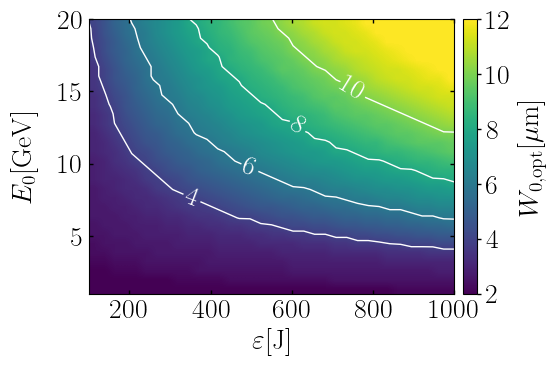

In [46]:
X,Y=np.meshgrid(Elst,E0lst)
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

im0 = axes.imshow(W0opt_th.T, interpolation='bilinear', origin='lower', extent=[min(Elst), max(Elst), min(E0lst), max(E0lst)],
              vmax=np.max(W0opt_th), vmin=2, cmap='viridis')#cm.Blues_r
axes.images.append(im0)
axes.set_xlabel(r'$\varepsilon[\mathrm{J}]$')
axes.set_ylabel(r'$E_0[\mathrm{GeV}]$',labelpad=15)
axes.tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True, color='black')
axes.tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True, color='black')
axes.set_xticks([200,400,600,800,1000])
axes.set_yticks([5,10,15,20])

fmt = {}
cplevels = [4,6,8,10]
strs = ['4','6','8','10']
for l, s in zip(cplevels, strs):
    fmt[l] = s
cp = axes.contour(X, Y, W0opt_th.T, cplevels, colors='white', linewidths=1.0)
manual_locations = [(300, 3), (500, 10), (600, 12), (770,16)]
tmp1 = axes.clabel(cp, cplevels, inline = True, fmt = fmt, fontsize=20, colors='white',manual=manual_locations)

cbar0 = fig.colorbar(im0, ax=axes, pad=0.02)
cbar0.set_ticks([2,4,6,8,10,12])
cbar0.set_label(r'$W_{0,\mathrm{opt}}[\mu \mathrm{m}]$')

# aspect
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes.set_aspect(aspect=3/4/axesratio)
# final
plt.tight_layout()
plt.savefig('Optimum_g0_a.pdf')
plt.show()

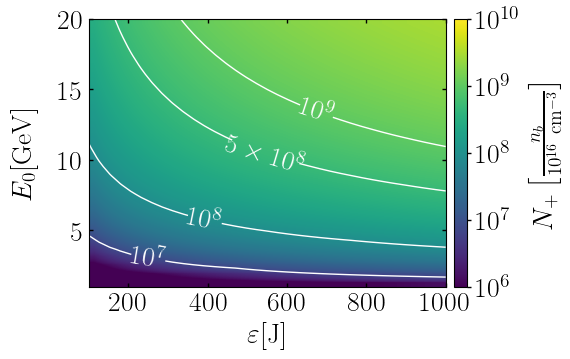

In [47]:
plt.style.use("style.txt")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

im1 = axes.imshow(Npopt_th.T, interpolation='bilinear', origin='lower', extent=[min(Elst), max(Elst), min(E0lst), max(E0lst)],
             norm=colors.LogNorm(vmax=1e10, vmin=1e6) , cmap='viridis')#cm.Blues_r
axes.images.append(im1)
axes.set_xlabel(r'$\varepsilon[\mathrm{J}]$')
axes.set_ylabel(r'$E_0[\mathrm{GeV}]$',labelpad=15)
axes.tick_params(which='both',axis="y",direction="in", labelleft=True, labelright=False, left=True, right=True, color='black')
axes.tick_params(which='both',axis="x",direction="in", labeltop=False, labelbottom=True, top=True, bottom=True, color='black')
axes.set_xticks([200,400,600,800,1000])
axes.set_yticks([5,10,15,20])

X,Y=np.meshgrid(Elst,E0lst)
fmt = {}
cplevels = [1e7,1e8,5e8,1e9]
strs = [r'$10^7$',r'$10^8$',r'$5\times10^8$',r'$10^9$']
for l, s in zip(cplevels, strs): fmt[l] = s
cp = axes.contour(X, Y, Npopt_th.T, cplevels, colors='white', linewidths=1.0)
manual_locations = [(250, 3), (400, 7), (560, 12), (700,16)]
tmp1 = axes.clabel(cp, cplevels, inline = True, fmt = fmt, fontsize=20, colors='white',manual=manual_locations)

cbar1 = fig.colorbar(im1, ax=axes, pad=0.02, fraction=0.1)
cbar1.set_ticks([1e5,1e6,1e7,1e8,1e9,1e10])
cbar1.set_label(r'$N_+ \left[ \frac{n_b}{10^{16}~ \mathrm{cm}^{-3}} \right]$',labelpad=5)
# aspect
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
axesratio = (ymax-ymin)/(xmax-xmin)
axes.set_aspect(aspect=3/4/axesratio)
# final
plt.tight_layout()
plt.savefig('Optimum_g0_b.pdf')
plt.show()